In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import cosine_similarity

#### Since this is just a PoC, using a simple, sample data construct

In [2]:
# Sample user entitlement data
user_entitlements = {
    'Henson': ['e1', 'e2', 'e3'],
    'Wade': ['e2', 'e4'],
    'Morrow': ['e1', 'e3', 'e2'],
    'Pham': ['e6', 'e7', 'e8'],
    'Valdez': ['e6', 'e7', 'e8'],
    'Evans': ['e6', 'e7', 'e8','e2','e4','e1','e2'],
    'Tony': ['e1', 'e3', 'e5','e2'],
    'Sam': ['e1', 'e3', 'e5'],
    'Eli': ['e1', 'e3', 'e5'],
    'Noor': ['e1', 'e3', 'e5'],
    'Fraz': ['e1', 'e3', 'e5']
    
}

#### Now, lets draw a graph, 
with <b>users</b> and <b>entitlements</b> as <b>nodes</b>, and <b>edges</b> connecting each <b>user to their corresponding entitlements</b>. Like in this sample data, the <b>node 'Henson'</b>, must be <b>connected to nodes 'e1','e2','e3'</b>

In [3]:
# Create an empty graph
graph = nx.Graph()

# Add nodes for users and entitlements
'''Loop through each item(key value pair, where key is the 'userID', and 
value is the corresponding entitlements for this userID) in the dictionary'''
for user, entitlements in user_entitlements.items():
    graph.add_node(user)
    for entitlement in entitlements:
        graph.add_node(entitlement)
        graph.add_edge(user, entitlement)
        graph.add_edge(entitlement, user, style='dashed')

In [4]:
'''Spring layout:
The algorithm simulates a force-directed representation of the network treating edges as springs holding nodes close,
while treating nodes as repelling objects, sometimes called an anti-gravity force. Simulation continues until the 
positions are close to an equilibrium.'''

'Spring layout:\nThe algorithm simulates a force-directed representation of the network treating edges as springs holding nodes close,\nwhile treating nodes as repelling objects, sometimes called an anti-gravity force. Simulation continues until the \npositions are close to an equilibrium.'

###### TODO: Try incorporating Jaccard similarity as a repulsive force between nodes that have low similarity scores and as an attractive force between nodes with high similarity scores, and hence accordingly have the placement of nodes in the graph layout.

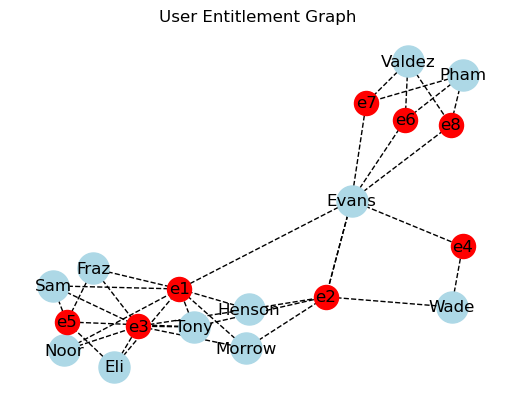

In [5]:
# Visualize the graph
pos = nx.spring_layout(graph)  # Layout algorithm for node positions

# Draw user nodes (The keys in the data dictionary are the user nodes)
nx.draw_networkx_nodes(graph, pos, nodelist=user_entitlements.keys(), node_color='lightblue', node_size=500)

# Draw entitlement nodes (From all the nodes added to the graph object, all nodes minus the user nodes are entitlements)
entitlement_nodes = [node for node in graph.nodes if node not in user_entitlements.keys()]
nx.draw_networkx_nodes(graph, pos, nodelist=entitlement_nodes, node_color='red', node_size=300)

# Draw labels
nx.draw_networkx_labels(graph, pos)

# Draw edges
user_edges = [(user, entitlement) for user in user_entitlements.keys() for entitlement in user_entitlements[user]]
#user_edges is a list of tuples, each tuple is (user, corresponding entitlement), hence 3 tuples for user 'u1',
# ('u1', 'e1'), ('u1', 'e2'), ('u1', 'e3'), and so on for remaining users
nx.draw_networkx_edges(graph, pos, edgelist=user_edges, width=1,style='dashed')

# Set plot title and axis off
plt.title('User Entitlement Graph')
plt.axis('off')

# Display the plot
plt.show()

##### Similar graph and relationship to users, from the perspective of accounts/entitlements with similarity based on what one can do we these accounts and privileges, workloads they provide access too, can provide useful insights too

#### Density clustering based on user node positions of the graph, and then based on similarity between users computed using Jaccard similarity concept

In [6]:
# Compute user similarity matrix( Jaccard similarity)
users = list(user_entitlements.keys())
user_similarities = np.zeros((len(users), len(users)))
for i, user1 in enumerate(users):
    for j, user2 in enumerate(users):
        entitlements1 = set(user_entitlements[user1])
        entitlements2 = set(user_entitlements[user2])
        similarity = len(entitlements1.intersection(entitlements2)) / len(entitlements1.union(entitlements2))
        user_similarities[i, j] = similarity

In [7]:
# Extract the user node positions as features for clustering
user_positions = np.array([pos[user] for user in user_entitlements])
#user_positions=user_similarities

# Perform density clustering using DBSCAN
epsilon = 0.5  # Maximum distance between samples to be considered as neighbors
min_samples = 2  # Minimum number of samples in a neighborhood for a point to be considered as a core point
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
labels = dbscan.fit_predict(user_positions)


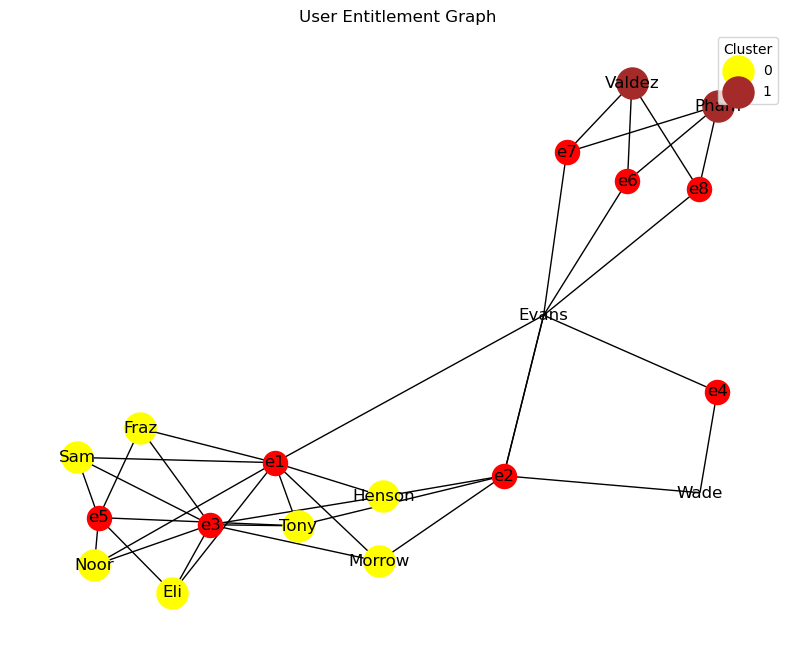

In [8]:
# Visualize the graph and clusters
plt.figure(figsize=(10, 8))

# Draw user nodes with different colors for each cluster
unique_labels = set(labels)
#creating colour maps(numbers(evenly spaced between 0 to 1) indicating colours, count of colours =number of unique labels)
#colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
colors=['yellow','brown']
for label, color in zip(unique_labels, colors):
    cluster_users = [user for user, label_val in zip(user_entitlements, labels) if label_val == label]
    nx.draw_networkx_nodes(graph, pos, nodelist=cluster_users, node_color=color, node_size=500, label=label)

# Draw entitlement nodes
entitlement_nodes = [node for node in graph.nodes if node not in user_entitlements.keys()]
nx.draw_networkx_nodes(graph, pos, nodelist=entitlement_nodes, node_color='red', node_size=300)

# Draw labels
nx.draw_networkx_labels(graph, pos)

# Draw edges
user_edges = [(user, entitlement) for user in user_entitlements.keys() for entitlement in user_entitlements[user]]
nx.draw_networkx_edges(graph, pos, edgelist=user_edges, width=1)

# Set plot title and legend
plt.title('User Entitlement Graph')
plt.legend(title='Cluster')

# Set plot axis off
plt.axis('off')

# Show the plot
plt.show()

#### Using Jaccard Similarity for distance between user nodes

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


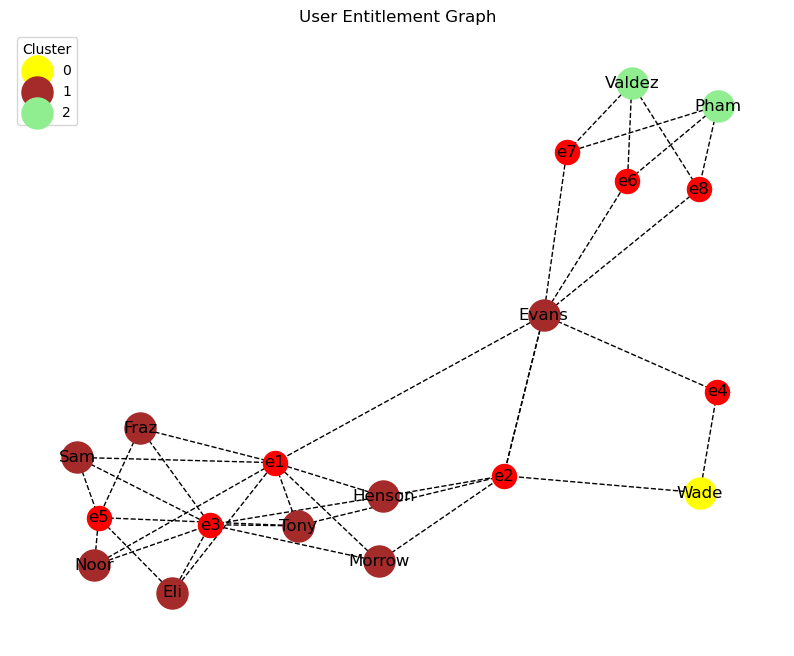

In [9]:
user_positions=user_similarities

# Perform clustering using spectral clustering
n_clusters = 3  # Number of clusters
spectral = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=42)
labels = spectral.fit_predict(user_similarities)

# Visualize the graph and clusters
plt.figure(figsize=(10, 8))

# Draw user nodes with different colors for each cluster
unique_labels = set(labels)
colors = ['yellow','brown','lightgreen']
for label, color in zip(unique_labels, colors):
    cluster_users = [user for user, label_val in zip(users, labels) if label_val == label]
    nx.draw_networkx_nodes(graph, pos, nodelist=cluster_users, node_color=color, node_size=500, label=label)

# Draw entitlement nodes
entitlement_nodes = [node for node in graph.nodes if node not in user_entitlements.keys()]
nx.draw_networkx_nodes(graph, pos, nodelist=entitlement_nodes, node_color='red', node_size=300)

# Draw labels
nx.draw_networkx_labels(graph, pos)

# Draw edges
user_edges = [(user, entitlement) for user in user_entitlements.keys() for entitlement in user_entitlements[user]]
nx.draw_networkx_edges(graph, pos, edgelist=user_edges, width=1, style='dashed')

# Set plot title and legend
plt.title('User Entitlement Graph')
plt.legend(title='Cluster')

# Set plot axis off
plt.axis('off')

# Show the plot
plt.show()

#### Find the users who have entitlements from multiple clusters

In [12]:
# Create a dictionary to store the cluster assignments for each user
user_clusters = {user: cluster for user, cluster in zip(user_entitlements.keys(), labels)}
#print(user_clusters)

# Create a dictionary to store the entitlement clusters for each user
user_entitlement_clusters = {user: set() for user in user_entitlements.keys()}
#print(user_entitlement_clusters)

number_of_entitlements=0
entitlements_set = set()
for entitlements in user_entitlements.values():
    number_of_entitlements += len(entitlements)
    entitlements_set.update(entitlements)
#print("entitlements_set ",entitlements_set)

entitlement_cluster = {entitlement: set() for entitlement in entitlements_set}
for user, entitlements in user_entitlements.items():
    for entitlement in entitlements:
        entitlement_cluster[entitlement].add(user_clusters[user])
#print(entitlement_cluster)

# Populate the entitlement clusters dictionary
for user, entitlements in user_entitlements.items():
    for entitlement in entitlements:
        user_entitlement_clusters[user].update(entitlement_cluster[entitlement])

# Identify user nodes that map to entitlements in multiple clusters(more than 1 cluster, could be kept configurable)
users_in_multiple_clusters = [user for user, clusters in user_entitlement_clusters.items() if len(clusters) > 1]




#### Following users have entitlements from multiple clusters. Candidates for micro certification --- User Access Review

In [11]:
# Print the user nodes that map to entitlements in multiple clusters
print("User nodes mapping to entitlements in multiple clusters:\n\n")
for user in users_in_multiple_clusters:
    print(user)

User nodes mapping to entitlements in multiple clusters:


Henson
Wade
Morrow
Pham
Valdez
Evans
Tony
